In [156]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import chardet


In [157]:


# # Detect the encoding of the CSV file
# with open( "C:\\Users\\mehme\\Desktop\\veriBilimiOdev\\customer_booking.csv", "rb") as f:
#     encoding = chardet.detect(f.read())["encoding"]

# Read the CSV file with the detected encoding
df = pd.read_csv("/home/mehmet/Desktop/yedek/masaüstü/dersler/ödevler/veriBilimiOdev/customer_booking.csv")

# Print the head of the DataFrame
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [158]:
def grab_col_names(df, cat_th = 10, car_th = 20):
    cat_cols = [ col for col in df.columns if str(df[col].dtypes) in [ "category", "object","bool"]]
    num_but_cat = [col for col in df.columns if df[col].nunique()  < 10 and df[col].dtypes in ["int64","float64"]]
    cat_but_car = [col for col in df.columns if df[col].nunique() > 20 and str(df[col].dtypes) in ["category","object"]]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in df.columns if df[col].dtypes in ["int64","float64"]]
    num_cols = [col for col in df.columns if col not in cat_cols]

    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car


In [159]:
def find_missing_values(df):
  """
  Bu fonksiyon, bir Pandas veri çerçevesindeki tüm sütunlar için eksik değerleri bulur ve yazar.

  Args:
    df (pandas.DataFrame): Eksik değerleri bulunacak veri çerçevesi.

  Returns:
    None: Fonksiyon herhangi bir değer döndürmez, eksik değerleri ekrana basar.
  """

  # Eksik değerlerin sayısını her sütun için hesaplayın
  missing_values = df.isnull().sum()

  # Eksik değerleri olan sütunları filtreleyin
  missing_cols = missing_values[missing_values > 0].index

  # Eksik değerleri olan sütunları ve sayılarını ekrana basın
  if len(missing_cols) > 0:
    print("Eksik Değerlere Sahip Sütunlar:")
    for col in missing_cols:
      print(f"{col}: {missing_values[col]}")
  else:
    print("Veri setinde eksik değer bulunmamaktadır.")

In [160]:
def iqr_outliers(df, column_name, multiplier=1.5,low_th=0.05, up_th = 0.95):
  """
  Bu fonksiyon, bir Pandas veri çerçevesindeki belirli bir sütun için IQR yöntemiyle aykırı değerleri tespit eder.

  Args:
    df (pandas.DataFrame): Veri çerçevesi.
    column_name (str): Aykırı değerleri tespit etmek istediğiniz sütun adı.
    multiplier (float, isteğe bağlı): IQR değerinin çarpılacağı katsayı (varsayılan 1.5).
    low_th(float): Q1 için yüzdelik değeri (varsayılan 0.05)
    up_th(float): Q3 için yüzdelik değeri (varsayılan 0.95)

  Returns:
    pandas.Series: Aykırı değerlerin True/False flaglardan oluşan bir seri.
  """
  low_th = float(low_th)
  up_th = float(up_th)

  data = df[column_name].copy()

  Q1 = data.quantile(low_th)
  Q3 = data.quantile(up_th)

  IQR = Q3 - Q1

  lower_bound = Q1 - (multiplier * IQR)
  upper_bound = Q3 + (multiplier * IQR)
  is_outlier = (data < lower_bound) | (data > upper_bound)

  return is_outlier

In [161]:
def label_encoder(df, categorical_columns):
    le = LabelEncoder()
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col])
    return df

In [162]:
def replace_with_mean(df, column_name):
  """
  Bu fonksiyon, bir Pandas veri çerçevesindeki belirli bir sütunun aykırı değerlerini ortalama ile değiştirir.

  Args:
    df (pandas.DataFrame): Veri çerçevesi.
    column_name (str): Aykırı değerleri ortalama ile değiştireceğiniz sütun adı.

  Returns:
    pandas.DataFrame: Aykırı değerleri ortalama ile değiştirilmiş veri çerçevesi.
  """

  # Aykırı değerleri tespit edin
  outliers = iqr_outliers(df, column_name)

  # Ortalamayı hesaplayın
  mean = df[column_name][~outliers].mean()

  # Aykırı değerleri ortalama ile değiştirin
  df.loc[outliers, column_name] = round(mean)

  return df

# Sayısal sütunlarda aykırı değerleri ortalama ile değiştirin
for col in num_cols:
  df = replace_with_mean(df, col)


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [164]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_passengers,50000.0,1.591240,1.020165,1.00,1.00,1.00,2.00,9.0
purchase_lead,50000.0,84.924840,90.383732,0.00,21.00,51.00,115.00,704.0
length_of_stay,50000.0,21.535920,26.106904,0.00,5.00,17.00,28.00,205.0
flight_hour,50000.0,9.066340,5.412660,0.00,5.00,9.00,13.00,23.0
wants_extra_baggage,50000.0,0.668780,0.470657,0.00,0.00,1.00,1.00,1.0
wants_preferred_seat,50000.0,0.296960,0.456923,0.00,0.00,0.00,1.00,1.0
wants_in_flight_meals,50000.0,0.427140,0.494668,0.00,0.00,0.00,1.00,1.0
flight_duration,50000.0,7.277561,1.496863,4.67,5.62,7.57,8.83,9.5
booking_complete,50000.0,0.149560,0.356643,0.00,0.00,0.00,0.00,1.0


## eksik değerler

In [165]:
df.isna().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

## sütunlardaki tekil sınıflar

In [166]:
for col in df.columns:
  print(col, ": ", df[col].nunique())

num_passengers :  9
sales_channel :  2
trip_type :  3
purchase_lead :  469
length_of_stay :  196
flight_hour :  24
flight_day :  7
route :  799
booking_origin :  104
wants_extra_baggage :  2
wants_preferred_seat :  2
wants_in_flight_meals :  2
flight_duration :  21
booking_complete :  2


## cat vs num cols
aşağıdaki hücrede tekil değer sayısına göre cat ve num col tespiti yapılmıştır

In [167]:
cat_cols = ["num_passengers", "sales_channel", "trip_type", "flight_day", "route", "booking_origin","wants_extra_baggage","wants_preferred_seat","wants_in_flight_meals","flight_duration"]
num_cols = [col for col in df.columns if col not in cat_cols]
num_cols.remove("booking_complete")

print(cat_cols)
print(num_cols)


['num_passengers', 'sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration']
['purchase_lead', 'length_of_stay', 'flight_hour']


<Figure size 4000x2500 with 0 Axes>

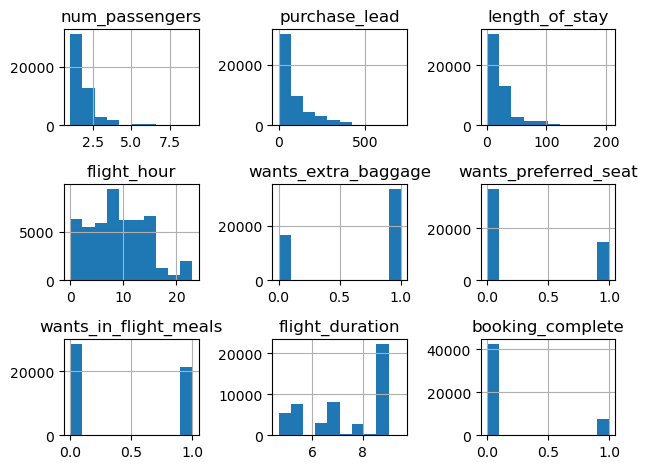

In [168]:
plt.figure(figsize=(40,25))
df.hist()
plt.tight_layout()
plt.show()

## num_passengers

/home/mehmet/Downloads/PREFIX=/home/mehmetokpc/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


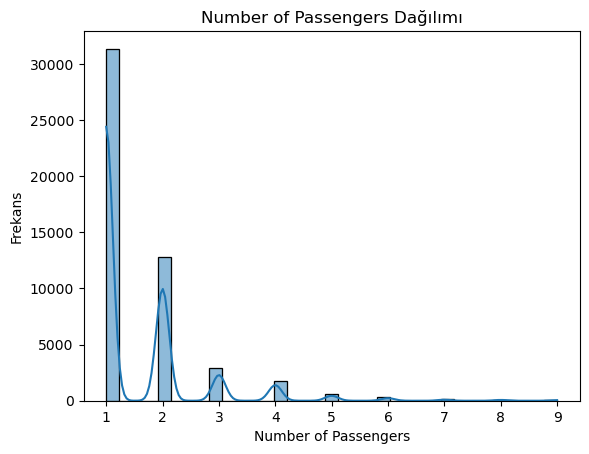

In [169]:
sns.histplot(df["num_passengers"],kde=True,bins = 35)
plt.title("Number of Passengers Dağılımı")
plt.xlabel("Number of Passengers")
plt.ylabel("Frekans")
plt.show()

## sales_channel

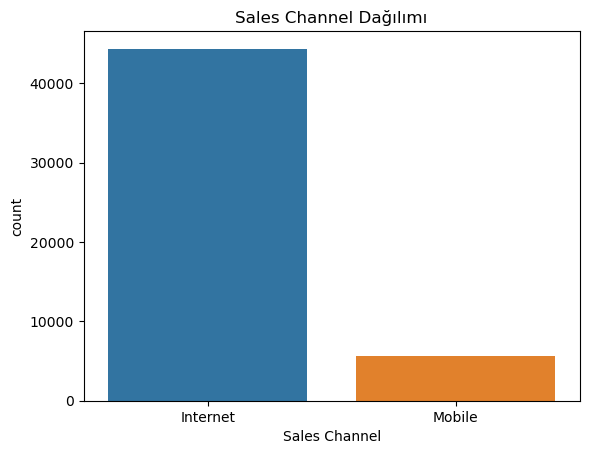

In [170]:
sns.countplot(x="sales_channel", data = df)
plt.title("Sales Channel Dağılımı")
plt.xlabel("Sales Channel")
plt.show()

## purchase_lead

/home/mehmet/Downloads/PREFIX=/home/mehmetokpc/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


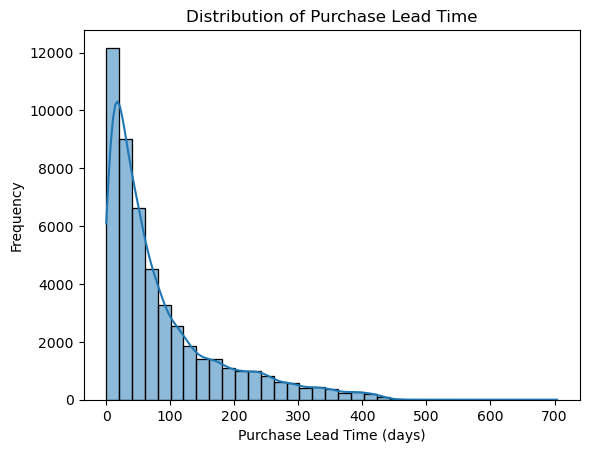

In [171]:
sns.histplot(df['purchase_lead'], bins=35 , kde=True)
plt.title('Distribution of Purchase Lead Time')
plt.xlabel('Purchase Lead Time (days)')
plt.ylabel('Frequency')
plt.show()

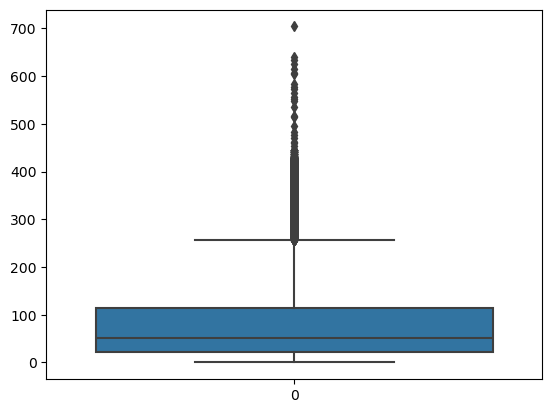

In [172]:
sns.boxplot(df["purchase_lead"])
plt.show()

## flight_duration

/home/mehmet/Downloads/PREFIX=/home/mehmetokpc/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


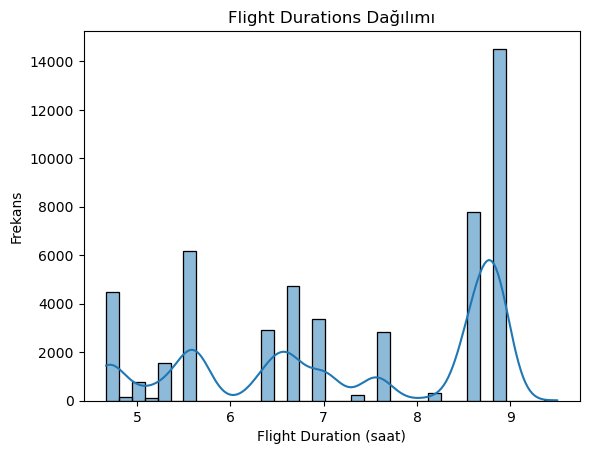

In [173]:
sns.histplot(df["flight_duration"],bins = 35, kde=True)
plt.title('Flight Durations Dağılımı')
plt.xlabel('Flight Duration (saat)')
plt.ylabel('Frekans')
plt.show()

## booking_complete

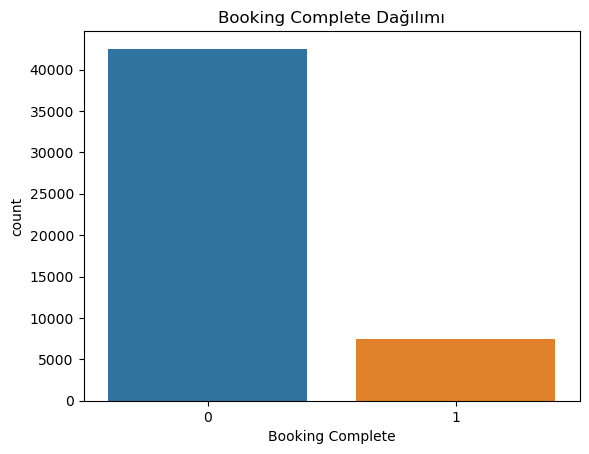

In [174]:
sns.countplot(x="booking_complete", data = df)
plt.title("Booking Complete Dağılımı")
plt.xlabel("Booking Complete")
plt.show()

## trip_type

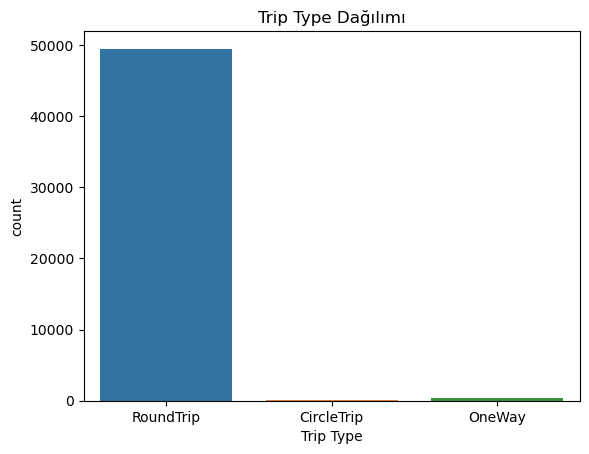

In [175]:
sns.countplot(x="trip_type", data = df)
plt.title("Trip Type Dağılımı")
plt.xlabel("Trip Type")
plt.show()

## booking_origin pie chart

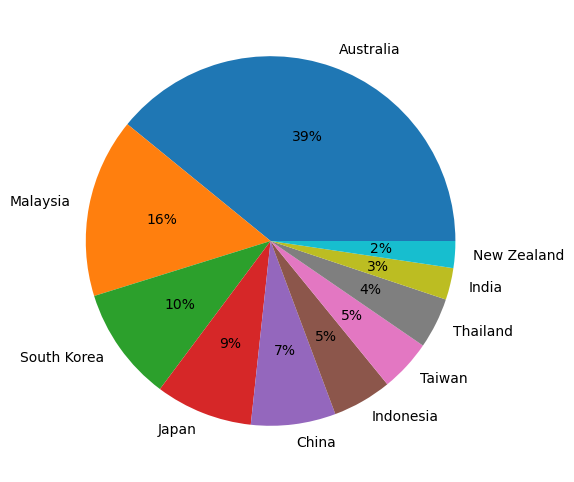

In [176]:
x=df['booking_origin'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(x.head(10),labels=x.head(10).index,autopct='%.0f%%')
plt.show()

## flight_day pie chart

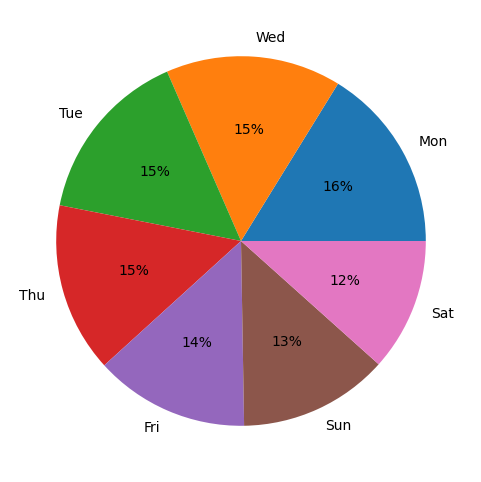

In [177]:
x=df['flight_day'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(x.head(10),labels=x.head(10).index,autopct='%.0f%%')
plt.show()

## label_encoder

In [178]:
df_lencoded = label_encoder(df,cat_cols)

In [179]:
df_lencoded.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,1,0,2,262,19,7,2,0,61,1,0,0,8,0
1,0,0,2,112,20,3,2,0,61,0,0,0,8,0
2,1,0,2,243,22,17,6,0,36,1,1,0,8,0
3,0,0,2,96,31,4,2,0,61,0,0,1,8,0
4,1,0,2,68,22,15,6,0,36,1,0,1,8,0


## aykırı değerler

In [180]:
outliers_col = []
for col in num_cols:
  print(col,"sütununda aykırı değer tespit edildi: ",iqr_outliers(df,col).any())
  if iqr_outliers(df,col).any():
    outliers_col.append(col)


print(outliers_col)

purchase_lead sütununda aykırı değer tespit edildi:  False
length_of_stay sütununda aykırı değer tespit edildi:  True
flight_hour sütununda aykırı değer tespit edildi:  False
['length_of_stay']


In [181]:
for col in num_cols:
  print(col,"sütununda aykırı değer tespit edildi: ",iqr_outliers(df,col).any())

purchase_lead sütununda aykırı değer tespit edildi:  False
length_of_stay sütununda aykırı değer tespit edildi:  True
flight_hour sütununda aykırı değer tespit edildi:  False


In [182]:
df = replace_with_mean(df, "length_of_stay")

In [183]:
for col in num_cols:
  print(col,"sütununda aykırı değer tespit edildi: ",iqr_outliers(df,col).any())

purchase_lead sütununda aykırı değer tespit edildi:  False
length_of_stay sütununda aykırı değer tespit edildi:  False
flight_hour sütununda aykırı değer tespit edildi:  False


## korelasyon ısı haritası

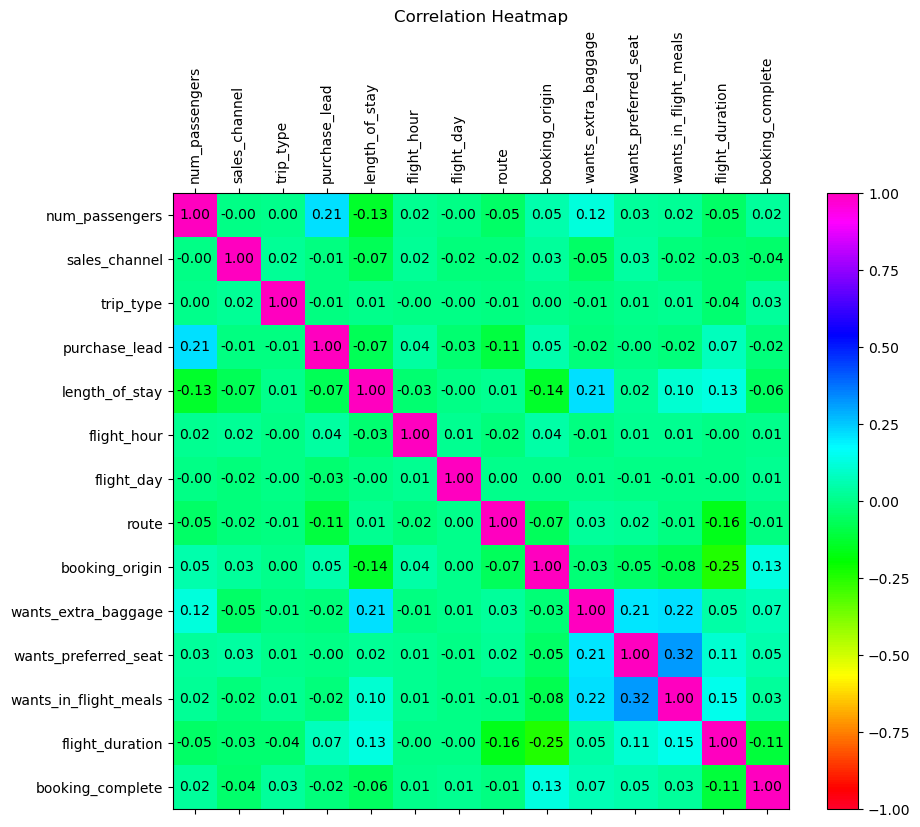

In [184]:
# Create a correlation matrix
corr_matrix = df_lencoded.corr()

# Isı haritası çizimi
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr_matrix, vmin=-1, vmax=1, cmap="gist_rainbow")
fig.colorbar(cax)

# Eksenler için ayarlamalar
ticks = np.arange(0, len(corr_matrix.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_matrix.columns, rotation = 90)
ax.set_yticklabels(corr_matrix.columns)

# Üzerine değerleri yazma
for (i, j), val in np.ndenumerate(corr_matrix.values):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

plt.title('Correlation Heatmap')
plt.show()

#### Yüksek korelasyonlu değişkenler olmadığı için herhangi bir işleme gerek yoktur.

## outliers

In [185]:
# num cols üzerinde outlier tespiti
outliers = pd.DataFrame()
for col in num_cols:
    if iqr_outliers(df_lencoded, col).any():
        print(col, " sütununda aykırı değer bulunmaktadır: True")
        outliers[col] = iqr_outliers(df_lencoded, col)
    else:
        print(col, " sütununda aykırı değer bulunmamaktadır: False")

purchase_lead  sütununda aykırı değer bulunmamaktadır: False
length_of_stay  sütununda aykırı değer bulunmamaktadır: False
flight_hour  sütununda aykırı değer bulunmamaktadır: False


In [186]:
# for col in outliers.columns:
#     replace_with_mean(df_lencoded, col)

replace_with_mean(df_lencoded, "length_of_stay")

outliers = pd.DataFrame()
for col in num_cols:
    if iqr_outliers(df_lencoded, col).any():
        print(col, " sütununda aykırı değer bulunmaktadır: True")
        outliers[col] = iqr_outliers(df_lencoded, col)
    else:
        print(col, " sütununda aykırı değer bulunmamaktadır: False")

purchase_lead  sütununda aykırı değer bulunmamaktadır: False
length_of_stay  sütununda aykırı değer bulunmamaktadır: False
flight_hour  sütununda aykırı değer bulunmamaktadır: False


## feature engineering

In [187]:
df_lencoded[num_cols].head()

,purchase_lead,length_of_stay,flight_hour
0,262,19,7
1,112,20,3
2,243,22,17
3,96,31,4
4,68,22,15


In [188]:
"""
   -Bu kisimda sayisal sütunlar çaprazlanarak yeni özellikler türetilmiştir.
   -Modele katkisi fazla olan özellikler elde tutularak gerisi silinecektir.
"""

num_cols_pairs = []
for i in range(len(num_cols)):
  for j in range(i + 1, len(num_cols)):
    num_cols_pairs.append((num_cols[i], num_cols[j]))

for col1, col2 in num_cols_pairs:
  new_col_name = f"{col1}_x_{col2}"
  df_lencoded[new_col_name] = df_lencoded[col1] * df_lencoded[col2]


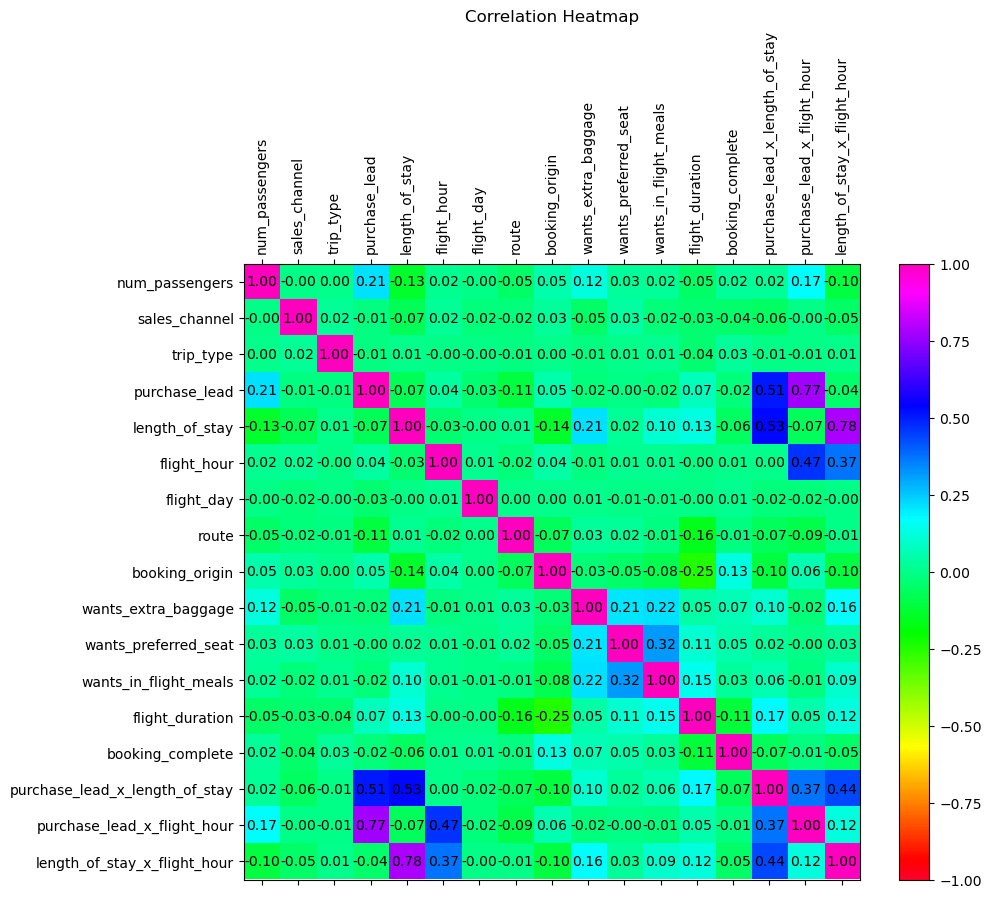

In [189]:
# Create a correlation matrix
corr_matrix = df_lencoded.corr()

# Isı haritası çizimi
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr_matrix, vmin=-1, vmax=1, cmap="gist_rainbow")
fig.colorbar(cax)

# Eksenler için ayarlamalar
ticks = np.arange(0, len(corr_matrix.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_matrix.columns, rotation = 90)
ax.set_yticklabels(corr_matrix.columns)

# Üzerine değerleri yazma
for (i, j), val in np.ndenumerate(corr_matrix.values):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

plt.title('Correlation Heatmap')
plt.show()

#### purchase_lead_x_flight_hour ve length_of_stay_x_flight_hour değişkenleri yüksek korelasyonlu olduğu için drop işlemi uygulanacaktır.

In [190]:
x_drop_list = ["purchase_lead_x_flight_hour","length_of_stay_x_flight_hour"]
df_lencoded.drop(x_drop_list, axis=1, inplace=True)
df_lencoded.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete',
       'purchase_lead_x_length_of_stay'],
      dtype='object')

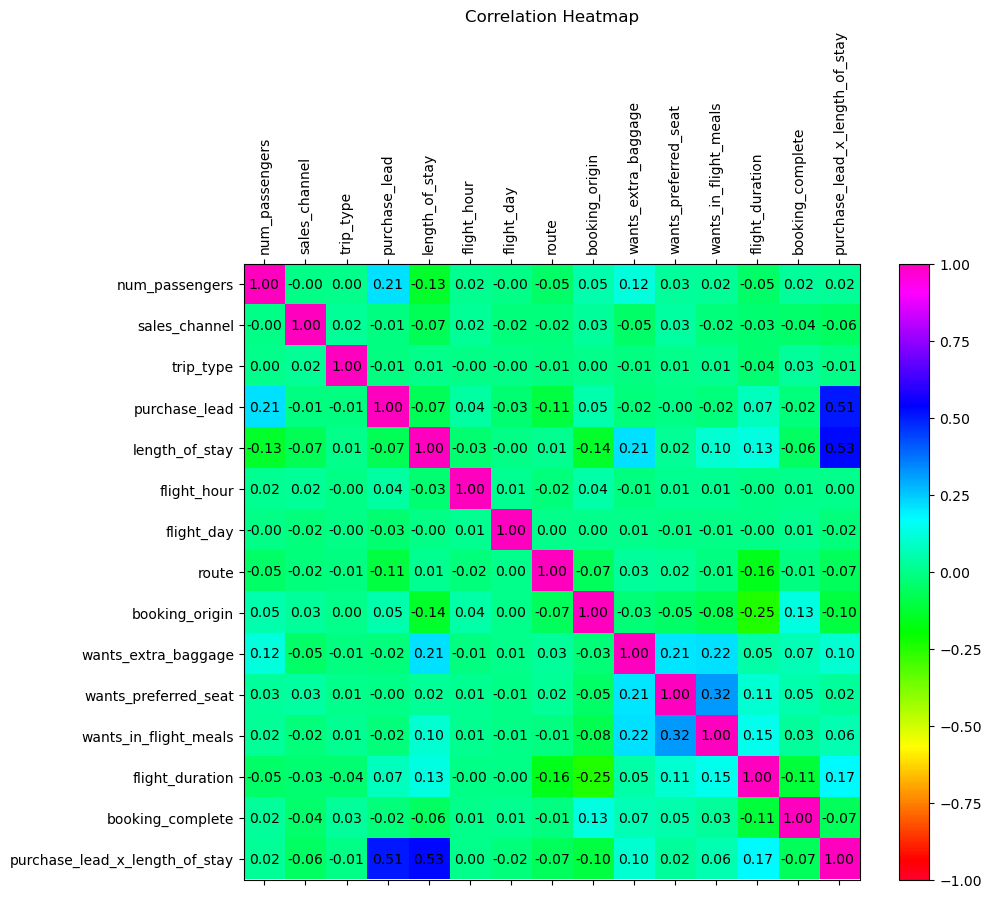

In [191]:
# Create a correlation matrix
corr_matrix = df_lencoded.corr()

# Isı haritası çizimi
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr_matrix, vmin=-1, vmax=1, cmap="gist_rainbow")
fig.colorbar(cax)

# Eksenler için ayarlamalar
ticks = np.arange(0, len(corr_matrix.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_matrix.columns, rotation = 90)
ax.set_yticklabels(corr_matrix.columns)

# Üzerine değerleri yazma
for (i, j), val in np.ndenumerate(corr_matrix.values):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

plt.title('Correlation Heatmap')
plt.show()

## normalizasyon

In [145]:

scaler = MinMaxScaler()
df_lencoded_normalized = df_lencoded.copy()

df_lencoded_normalized = pd.DataFrame(scaler.fit_transform(df_lencoded_normalized), columns=df_lencoded_normalized.columns)

df_lencoded_normalized.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,purchase_lead_x_length_of_stay
0,0.125,0.0,1.0,0.372159,0.098446,0.304348,0.333333,0.0,0.592233,1.0,0.0,0.0,0.4,0.0,0.089636
1,0.000,0.0,1.0,0.159091,0.103627,0.130435,0.333333,0.0,0.592233,0.0,0.0,0.0,0.4,0.0,0.040334
2,0.125,0.0,1.0,0.345170,0.113990,0.739130,1.000000,0.0,0.349515,1.0,1.0,0.0,0.4,0.0,0.096262
3,0.000,0.0,1.0,0.136364,0.160622,0.173913,0.333333,0.0,0.592233,0.0,0.0,1.0,0.4,0.0,0.053587
4,0.125,0.0,1.0,0.096591,0.113990,0.652174,1.000000,0.0,0.349515,1.0,0.0,1.0,0.4,0.0,0.026937


## Verinin train-test setlerine bölünmesi

In [155]:
X = df_lencoded_normalized.drop("booking_complete", axis = 1)
y = df_lencoded_normalized["booking_complete"]

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [194]:
#support vector machine eğitimi
from sklearn.svm import SVC
model = SVC(kernel='rbf') 
model.fit(X_train, y_train)

SVC()

In [195]:
#decision tree classifier eğitimi
from sklearn.tree import DecisionTreeClassifier
dt_model  = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)

DecisionTreeClassifier()

In [196]:
#random forest classifier eğitimi
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(n_estimators=50)
rfc_model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

In [197]:
#modeller ile tahminleme işlemi 
dt_pred = dt_model.predict(X_test)
svm_pred = model.predict(X_test)
rf_pred = rfc_model.predict(X_test)

In [199]:
from sklearn.metrics import confusion_matrix

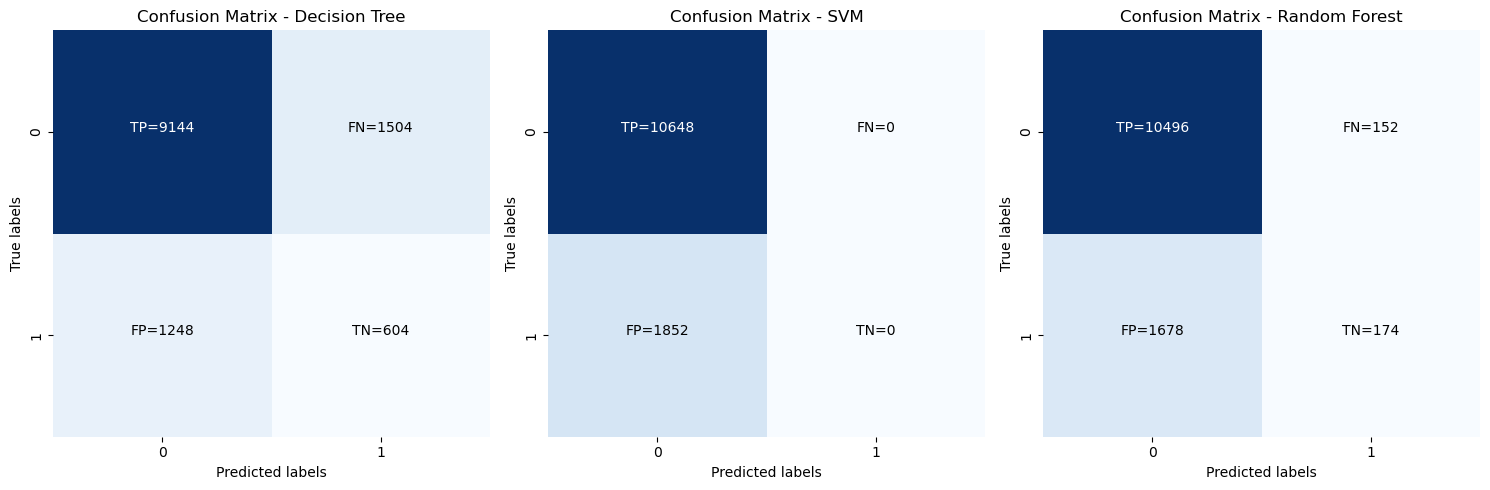

In [209]:
#modeller için confusion matrixler
models = {'Decision Tree': dt_pred, 'SVM': svm_pred, 'Random Forest': rf_pred}

plt.figure(figsize=(15, 5))
for i, (model_name, pred) in enumerate(models.items()):
    plt.subplot(1, 3, i+1)
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    plt.text(0.5, 0.5, f'TP={cm[0, 0]}', color='white', ha='center')
    plt.text(1.5, 0.5, f'FN={cm[0, 1]}', color='black', ha='center')
    plt.text(0.5, 1.5, f'FP={cm[1, 0]}', color='black', ha='center')
    plt.text(1.5, 1.5, f'TN={cm[1, 1]}', color='black', ha='center')

plt.tight_layout()
plt.show()

In [208]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Her bir model için metrik değerlerini hesapla
metrics = {}
for model_name, pred in models.items():
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    metrics[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

# Sonuçları tablo şeklinde yazdırma
print("{:<15} {:<10} {:<10} {:<10} {:<10}".format('Model', 'Accuracy', 'Precision', 'Recall', 'F1-score'))
for model_name, metric in metrics.items():
    print("{:<15} {:.4f}     {:.4f}     {:.4f}     {:.4f}".format(model_name, metric['Accuracy'], metric['Precision'], metric['Recall'], metric['F1-score']))


Model           Accuracy   Precision  Recall     F1-score  
Decision Tree   0.7798     0.2865     0.3261     0.3051
SVM             0.8518     0.0000     0.0000     0.0000
Random Forest   0.8536     0.5337     0.0940     0.1598


/home/mehmet/Downloads/PREFIX=/home/mehmetokpc/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
""" 
SVM modeli yüksek accuracy sağlamasına rağmen başarısız olmuştur.
"""